# Testing DEMV on Compas dataset

In [3]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, DemographicParity

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [4]:
data = pd.read_csv('data2/compas.csv', index_col=0)

In [5]:
label = 'two_year_recid'
sensitive_vars = ['sex','race']
protected_group = {'sex':0, 'race': 0}
positive_label = 0

In [6]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear'))
])

## Biased Data

In [7]:
model, biasmetrics, y_pred= cross_val2(pipeline, data, label, protected_group, sensitive_vars, positive_label=0)

In [8]:
print_metrics(biasmetrics)

Statistical parity:  -0.265  +-  0.041
Disparate impact:  0.614  +-  0.055
Zero one loss:  0.136  +-  0.051
F1 score:  0.667  +-  0.018
Accuracy score:  0.667  +-  0.018


## DEMV Data

In [9]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [10]:
model, demv_metrics = cross_val(pipeline, demv_data, label, protected_group, sensitive_vars, debiaser=demv, positive_label=0)

In [11]:
print_metrics(demv_metrics)

Statistical parity:  -0.106  +-  0.046
Disparate impact:  0.822  +-  0.069
Zero one loss:  0.099  +-  0.042
F1 score:  0.664  +-  0.016
Accuracy score:  0.664  +-  0.016


## DEMV Evaluation

In [12]:
metrics = eval_demv(29, 116, data.copy(), pipeline, label, protected_group, sensitive_vars, positive_label=0)

##  Blackbox PostProcessing

In [13]:
sensitive_features = ['combined']
unpriv_group = {'combined': 1}

In [15]:
from balancers import PredictionBalancer

data.loc[:,"combined"] = 0
data.loc[(data['sex'] == 0) & (data["race"] == 0),"combined"] = 1

a = data.combined.values

y_ = []
for list in y_pred:
    for j in list:
        y_.append(int(j))

y_ = np.array(y_)

y_ = np.array(y_ == 0 , dtype=np.uint8)

y = np.array(data.two_year_recid == 0, dtype=np.uint8)
y = np.array(y)


In [16]:
pb = PredictionBalancer(y=y, y_=y_, a=a)

y_adj = pb.adjust(summary = True)


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.5362 0.5503
   1.0 0.5327 0.5393

And loss is 0.4910


Post-adjustment group rates are 

 group    fpr    tpr
   0.0 0.5183 0.5480
   1.0 0.5327 0.5393

And loss is 0.4886



In [17]:
datapred = deepcopy(data)
datapred[label] = y_adj

blackboxmetrics = get_metrics( data, datapred , unpriv_group, label, positive_label   )

##  Plot

In [18]:
df = prepareplots(metrics,'compas')

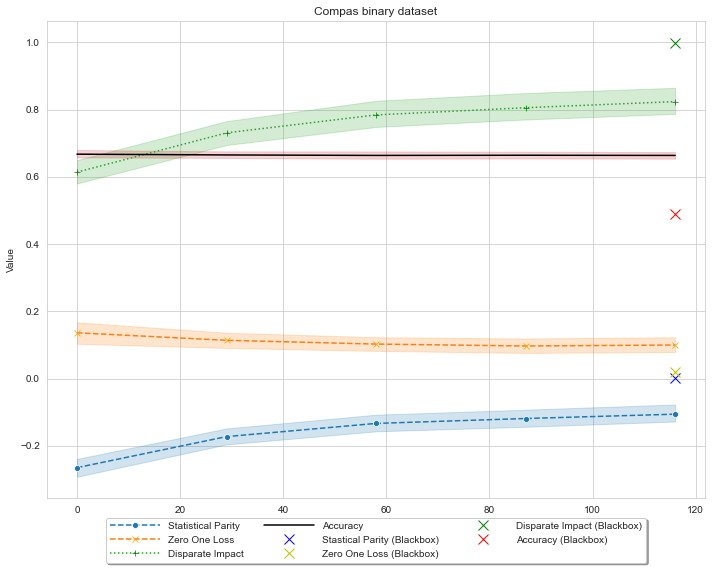

In [19]:
points = preparepoints(blackboxmetrics,demv.get_iters())
plot_metrics_curves(df, points, 'Compas binary dataset')

In [20]:
unprivpergentage(data,protected_group, demv.get_iters())

Dataset size: 6167
Unprivileged group size: 3374
Percentage of unprivileged group: 54.710556186152104
Number of iterations: 116
